In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
from scipy.sparse import csr_matrix
import sklearn
import gget
import scanpy.external as sce

# local
import plotting as plt2
import utils as ut

sc.settings.verbosity = 3  

# Load iHSC data

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/magic.ihsc.h5ad"
adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
sc.logging.print_memory_usage()
adata

Memory usage: current 4.93 GB, difference +4.93 GB


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'magic', 'raw_counts'
    obsp: 'connectivities', 'dista

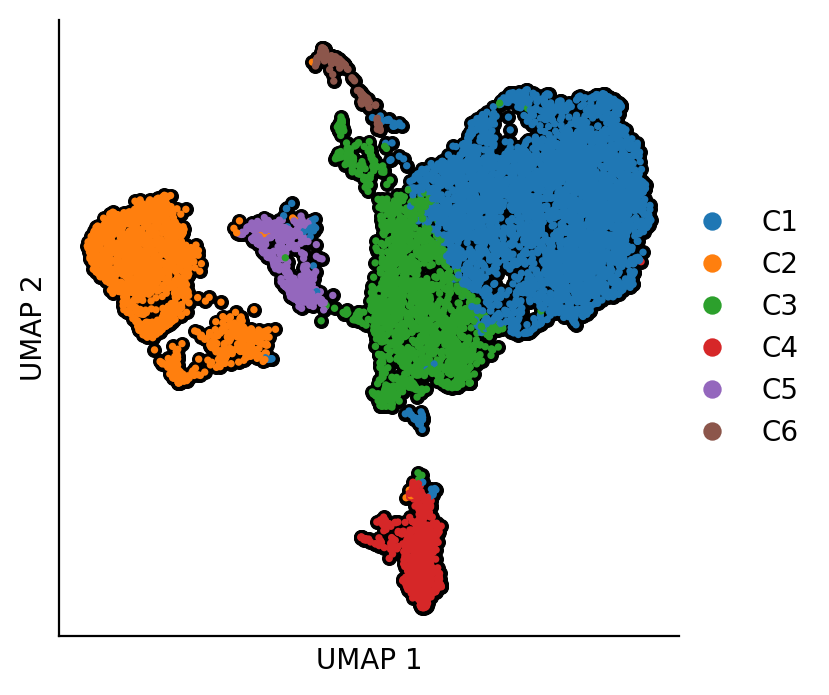

In [3]:
def plot_clusters(adata=adata, ax=None, legend=True):
    
    if ax is None:
        fig, ax = plt.subplots()
        
    sns.scatterplot(
        data=adata.obs,
        x='UMAP 1',
        y='UMAP 2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    sns.scatterplot(
        data=adata.obs,
        x='UMAP 1',
        y='UMAP 2',
        ec='none',
        hue='cluster_str',
        s=7,
        # palette=colors,
        hue_order=sorted(adata.obs['cluster_str'].unique()),
        legend=legend,
        zorder=3,
        ax=ax,
    )
    plt.axis('auto')
    
    if legend:
        sns.move_legend(
            ax,
            title='',
            loc='center',
            markerscale=2.5,
            ncol=1,
            frameon=False,
            bbox_to_anchor=(1.1, 0.5),
        )
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine()
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
plot_clusters()

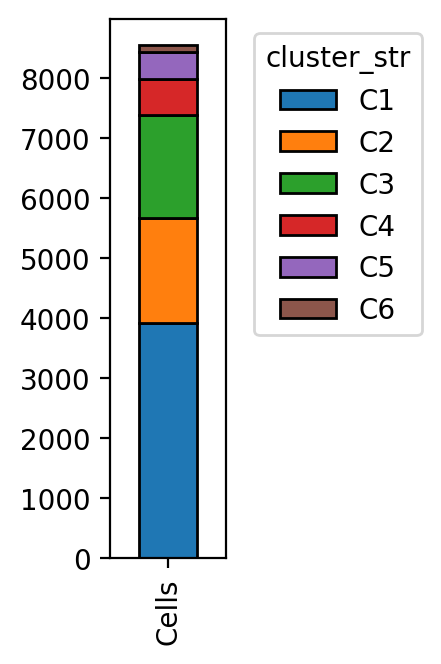

In [4]:

value_counts = adata.obs['cluster_str'].value_counts()
value_counts = value_counts.rename('Cells')
value_counts = pd.DataFrame(value_counts).T

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 0.75, 3.5

value_counts.plot(
    kind='bar', 
    stacked=True,
    ec='k',
)
sns.move_legend(
    plt.gca(), 
    loc='upper right',
    bbox_to_anchor=(2.8, 1),
)


In [5]:
def plot_gene_expression(exp_df, pdf, gene, cmap='viridis', ax=None, colorbar=True):
    """
    Plots gene expression on UMAP coordinates with color gradient.

    Args:
        exp_df: DataFrame containing gene expression data.
        pdf: DataFrame containing UMAP coordinates.
        gene: The gene to plot.
    """

    vector = exp_df[gene].values
    sorted_idx = np.argsort(vector)
    vmax = vector.max()
    vmin = vector.min()
    
    if ax is None:
        fig, ax = plt.subplots()

    # Base scatterplot (black dots)
    sns.scatterplot(
        data=pdf,
        x='UMAP 1',
        y='UMAP 2',
        ec='k',
        color='k',
        s=25,
        zorder=1,
        ax=ax,
    )

    # Expression-colored scatterplot
    sns.scatterplot(
        data=pdf.iloc[sorted_idx],
        x='UMAP 1',
        y='UMAP 2',
        ec='none',
        hue=vector[sorted_idx],
        palette=cmap,
        s=8,
        zorder=1,
        legend=False,
        ax=ax,
    )

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(gene)
    sns.despine(left=True, bottom=True)


    if colorbar:
        # Create colorbar
        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # This is necessary for the colorbar to work

        # Add colorbar to the plot
        cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.45)
    
    plt.axis('auto')

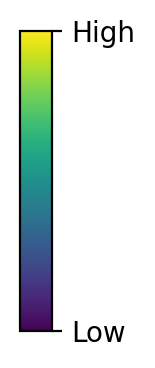

In [6]:
plt2.make_colorbar(tick_labels=['Low', 'High'])

In [7]:
# break

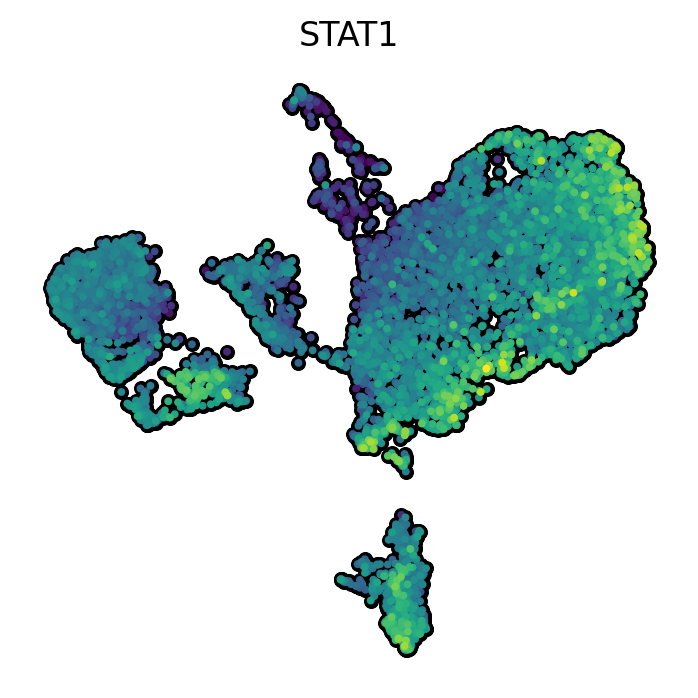

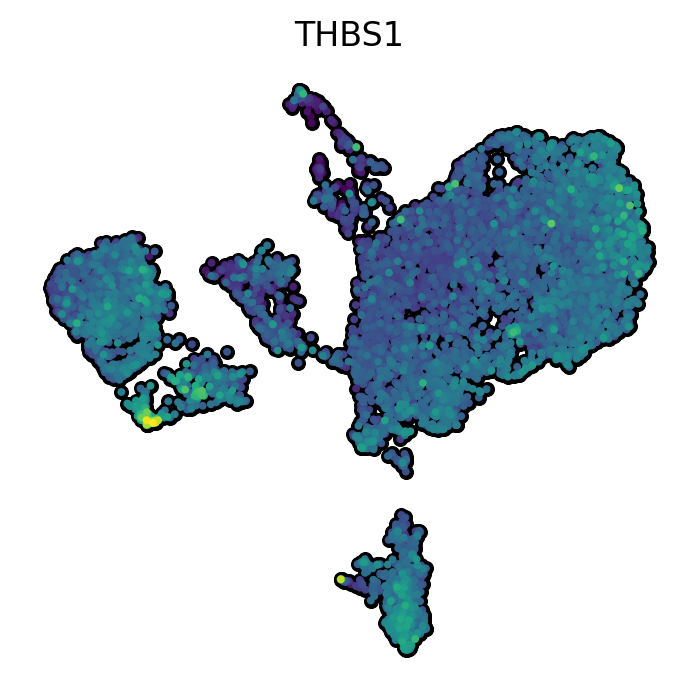

In [23]:
gene_list = [
    'STAT1',
    'THBS1',
]

layer = 'magic'

pdf = adata.obs.copy()
exp_df = adata[:, gene_list].to_df(layer=layer)

for gene in gene_list:
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 4.25, 4
    plot_gene_expression(exp_df, pdf, gene, cmap='viridis', colorbar=False)
    # break

In [20]:
deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='deg',
)

# alpha = 0.05
# deg = deg[deg['pvals_adj'] < alpha]
deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,0,ZNF416,59.107777,2.441200,0.0,0.0,0.999491,0.869284
1,0,IL4I1,54.698078,1.929153,0.0,0.0,1.000000,0.942623
2,0,ZFP82,53.811306,1.988346,0.0,0.0,0.998217,0.837144
3,0,UBE2S,53.667488,2.156020,0.0,0.0,0.996690,0.828516
4,0,LRG1,52.178192,2.069696,0.0,0.0,0.989305,0.707722


In [21]:
deg = deg[deg['names'].isin(gene_list)]
deg

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
2212,0,STAT1,1.935416,0.248240,0.052939,0.202205,0.198880,0.180759
4820,0,THBS1,0.468094,0.161027,0.639717,0.999785,0.078941,0.073770
25063,1,THBS1,-0.885258,-0.024277,0.376017,0.738718,0.063927,0.079284
27656,1,STAT1,-2.543543,-0.197260,0.010973,0.041505,0.150685,0.198943
34329,2,THBS1,0.071420,-0.080103,0.943064,0.999991,0.077869,0.075711
39466,2,STAT1,-0.492193,-0.155795,0.622583,0.999991,0.190281,0.188767
48649,3,STAT1,2.461552,0.273885,0.013834,0.054357,0.257475,0.183896
50005,3,THBS1,1.645854,0.356678,0.099794,0.279026,0.116279,0.073106
70987,4,STAT1,-0.143899,-0.263488,0.885580,0.999592,0.199105,0.188517
73037,4,THBS1,-0.649392,-0.665640,0.516085,0.999592,0.060403,0.077008


In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# stacked bars

In [ ]:
adata

In [ ]:
fpath = "../resources/Tabula_Sapiens.txt"
pdf = ut.load_pathway(fpath)  

columns = [
    'Blood-hematopoietic Stem Cell',
    'Bone Marrow-hematopoietic Stem Cell',
    'Lymph Node-hematopoietic Stem Cell',
    'Spleen-hematopoietic Stem Cell',
    'Bladder-fibroblast',
    'Bladder-myofibroblast Cell',
    'Lung-alveolar Fibroblast',
    'Large Intestine-fibroblast',
    'Lung-fibroblast',
    'Small Intestine-fibroblast',
    'Thymus-fibroblast',
    'Vasculature-fibroblast',
    'Mammary-fibroblast Of Breast',
    'Uterus-fibroblast',
    'Eye-fibroblast',
    'Liver-fibroblast',
    'Trachea-fibroblast',
    'Salivary Gland-fibroblast',
    'Tongue-fibroblast',
    'Prostate-fibroblast',
    'Pancreas-fibroblast',
    'Fat-fibroblast',
    'Heart-fibroblast Of Cardiac Tissue',
]

pdf = pdf[columns]
pdf = pdf[pdf.index.isin(adata.var_names)]
print(f"{pdf.shape=}")

pdf.head()

In [ ]:
result = []

layer = 'magic'
group = 'cluster_str'

exp_df = adata.to_df(layer=layer).replace(0.0, pd.NA)
exp_df['group'] = adata.obs[group].values

for column in pdf.columns:
    gene_list = list(pdf[pdf[column]].index)
    print(f"{column} {len(gene_list)}")
    
    row = exp_df.groupby('group')[gene_list].mean().mean(axis=1)
    row = row.to_dict()
    row['marker'] = column
    
    result.append(row)

    
result = pd.DataFrame(result)
print(f"{result.shape=}")
result = result.set_index("marker")
result

In [ ]:
sns.heatmap(result)

In [ ]:
gene_list = [
    'BRCA2', 
    'CD34', 
    'FOS', 
    'ERG',  
]

layer = 'raw_counts'
group = 'cluster_str'

pdf = adata.obs.copy()
exp_df = adata[:, gene_list].to_df(layer=layer).astype(bool)
exp_df[group] = pdf[group].values


# exp_df = exp_df.groupby(group).sum()
# exp_df = exp_df.divide(exp_df.sum(axis=0), axis=1) * 100

exp_df

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2.5, 4

exp_df.T.plot(
    kind='bar', 
    stacked=True,
    ec='k',
)
sns.move_legend(
    plt.gca(), 
    loc='upper right',
    bbox_to_anchor=(1.7, 1),
)


In [ ]:
1752 * 0.055

In [ ]:
pdf[group].value_counts()

In [ ]:
break